# Training data download pipeline

Downloads 16x16 training data plots from Sentinel Hub, with the following steps:

*  Convert coordinates to UTM, identify bounding boxes of 160 and 180 meter borders
*  Download all L1C steps, correct missing bands, and calculate cloud cover
*  Select L2A imagery corresponding to the best imagery per 15 days, with missing imagery calculated as the weighted average of the nearest time steps

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants, DataSource, CustomUrlParam
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml

import scipy.sparse as sparse
from scipy.sparse.linalg import splu


with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
DATA_LOCATION = '../data/test1.csv'
OUTPUT_FOLDER = '../data/validated-size-test/'
EPSG = CRS.WGS84
IMSIZE = 32
existing = [int(x[:-4]) for x in os.listdir(OUTPUT_FOLDER) if ".DS" not in x]

In [23]:
%run ../src/slope.py
%run ../src/utils.py
%run ../src/dsen2/utils/DSen2Net.py

In [24]:
# setup function to reproject coordinates
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(points, expansion = 160):
    # LONG, LAT FOR SOME REASON
    bl = list(points[0])
    tr = list(points[1])
    
    if 48 <= bl[0] <= 54:
        epsg = 32639 if bl[1] > 0 else 32739
    if 42 <= bl[0] <= 48:
        epsg = 32638 if bl[1] > 0 else 32738
    if 36 <= bl[0] <= 42:
        epsg = 32637 if bl[1] > 0 else 32737
    if 30 <= bl[0] <= 36:
        epsg = 32636 if bl[1] > 0 else 32736
    if 24 <= bl[0] <= 30:
        epsg = 32635 if bl[1] > 0 else 32735
    if 18 <= bl[0] <= 24:
        epsg = 32634 if bl[1] > 0 else 32734

    bl = convertCoords(bl, 4326, epsg)
    tr = convertCoords(tr, 4326, epsg)
    init = [b - a for a,b in zip(bl, tr)]
    distance1 = tr[0] - bl[0]
    distance2 = tr[1] - bl[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
   # EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    bl = [bl[0] - expansion1, bl[1] - expansion2]
    tr = [tr[0] + expansion1, tr[1] + expansion2]
    #bl = [a - expansion1 for a in bl]
    #tr = [a + expansion2 for a in tr]
    
    after = [b - a for a,b in zip(bl, tr)]   
    print(after)
    if max(init) > 130:
        print("ERROR: Initial field greater than 130m")
    if min(init) < 120:
        print("ERROR: Initial field less than 130m")
        
    if min(after) < (expansion - 4.5):
        print("ERROR")
    if max(after) > (expansion + 5):
        print("ERROR")
    diffs = [b - a for b, a in zip(after, init)]

    bl = convertCoords(bl, epsg, 4326)
    tr = convertCoords(tr, epsg, 4326)
    return bl, tr

location = calc_bbox(val)
location = bounding_box(location)
box = BBox(location, crs = EPSG)

image_request = WcsRequest(
                layer='ALL_BANDS_NDVI',
                bbox=box,
                time = ('2018-01-01', '2018-12-31'),
                image_format = MimeType.TIFF_d32f,
                maxcc=1,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
            )
img_bands = image_request.get_data()
img_bands[0].shape

In [25]:


def calc_bbox(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]


df = pd.read_csv(DATA_LOCATION)
df = df.drop('IMAGERY_TITLE', axis = 1)
df = df.dropna(axis = 0)
plot_ids = sorted(df['PLOT_ID'].unique())

In [26]:
bounding_box(calc_bbox(plot_ids[1]))

[160.0, 160.0]


([35.55597727919265, 6.495841371692717],
 [35.557430243403935, 6.497280000393161])

In [27]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

def calculate_proximal_steps(uniques, date, clean_steps):
    arg_before = None
    arg_after = None
    uniques = np.array(uniques)
    satisfactory = np.argwhere(uniques > 2)
    satisfactory = np.array([x for x in satisfactory if x in clean_steps])
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    print(arg_before, date, arg_after)
    return arg_before, arg_after

def calculate_proximal_steps_index(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    return arg_before, arg_after


def identify_clouds(bbox, epsg = EPSG, time = ('2018-12-15', '2019-12-01')):
    try:
        box = BBox(bbox, crs = epsg)
        cloud_request = WmsRequest(
            layer='CLOUD_DETECTION',
            bbox=box,
            time=time,
            width=32,
            height=32,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.33,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        cloud_img = cloud_request.get_data()
        cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
        means = np.mean(cloud_probs, (1, 2))
        clean_steps = [i for i, val in enumerate(means) if val < 0.20]
        return clean_steps, means, cloud_probs
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    
def download_dem(val, epsg = EPSG):
    location = calc_bbox(val)
    bbox = bounding_box(location, expansion = 340)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=IMSIZE+2,
                         height=IMSIZE+2,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, IMSIZE+2, IMSIZE+2)),
                  np.full((IMSIZE+2, IMSIZE+2), 10), np.full((IMSIZE+2, IMSIZE+2), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((IMSIZE+2, IMSIZE+2, 1))
    dem_image = dem_image[1:IMSIZE+1, 1:IMSIZE+1, :]
    return dem_image


def check_zenith(bbox, epsg = EPSG, time = ('2018-12-15', '2019-12-01')):
    try:
        box = BBox(bbox, crs = epsg)
        zenith = WmsRequest(
            layer='ZENITH',
            bbox=box,
            time=time,
            width=IMSIZE,
            height=IMSIZE,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.33,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        zenith = zenith.get_data()
        return zenith
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
        
    
def download_tiles(bbox, clean_steps, sz, epsg = EPSG, time = ('2018-12-15', '2019-12-01')):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WmsRequest(
                layer='L2A',
                bbox=box,
                time=time,
                width=sz,
                height=sz,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.33,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img_bands = np.array(img_bands)
        return img_bands, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)
    

        
def calculate_and_save_best_images(img_bands, image_dates):
    # This function interpolates data to 5 day windows linearly

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Clouds have been removed at this step, so all steps are satisfactory
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 5 days, select it
        if closest < 5:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 5 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 100: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 100:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                               
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    # Compute the weighted average of the selected imagery for each time step
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps, max_distance



In [28]:
def speyediff(N, d, format = 'csc'):
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

In [29]:
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

Symbolic Model Created.


In [30]:
from skimage.transform import resize
def download_layer(bbox, epsg = EPSG, time = ('2018-12-15', '2019-12-01'), res = '1m'):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.33,
                resx=res, resy=res,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img = np.stack(img_bands)
        print("Raw size: {}".format(img.shape))
        
        img = resize(img, (img.shape[0], 320, 320, img.shape[-1]))

        img_downsampled = np.zeros((img.shape[0], 32, 32, 10))
        for band in range(img.shape[-1]):
            if band in [0, 1, 2, 6]:
                t = np.reshape(img[:, :, :, band], (img.shape[0], 32, 10, 32, 10))
                t = np.mean(t, (2, 4))
                img_downsampled[:, :, :, band] = t
            else:
                t = np.reshape(img[:, :, :, band], (img.shape[0], 16, 20, 16, 20))
                t = np.mean(t, (2, 4))
                t = resize(t, (t.shape[0], 32, 32), order = 0)
                img_downsampled[:, :, :, band] = t
                
        print("Downsampled size: {}".format(img_downsampled.shape))
        return img_downsampled, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)
        
#location1 = bounding_box(location, expansion = 320)
#img = download_layer(location1, res = '1m')

In [31]:
to_download = [x for x in plot_ids if x not in existing]
errors = []
year = 2019
print("STARTING DOWNLOAD OF {} plots from {} to {}".format(len(to_download), DATA_LOCATION, OUTPUT_FOLDER))
for i, val in enumerate(plot_ids):
    if val not in existing:
        print("Downloading {}/{}, {}".format(i, len(plot_ids), val))
        location = calc_bbox(val)
        location = bounding_box(location, expansion = 320)
        #location2 = bounding_box(location, expansion = 159)
        #validate_sample_sizing(location2)
        try:
            # Identify cloud steps, download DEM, and download L2A series
            clean_steps, means, probs = identify_clouds(location)
            dem = download_dem(val)
            print("Downloading 32x32 img")
            img, image_request = download_layer(location, res = '1m')
            
            # Subset zenith < 70
            zenith = check_zenith(location)
            zenith = np.mean(np.stack(zenith), axis = (1, 2))
            zenith_outliers = np.argwhere(zenith > 70)
            if len(zenith_outliers) > 0:
                print("Zenith outlier: {}".format(zenith_outliers))
            
            # Calculate imagery dates
            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-360 + (date.month-1)*30 + date.day)
                if date.year == year:
                    image_dates.append((date.month-1)*30 + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + (date.month-1)*30+date.day)
            image_dates = np.array(image_dates)
            
            # Remove imagery where >4% is clouds, and where there is null data
            args = np.array([len(np.argwhere(probs[x, :, :].reshape((32)*(32)) > 0.3)) for x in range(probs.shape[0])])
            dirty_steps = np.argwhere(args > (32)*(32) / 25)
            missing_images = [np.argwhere(img[x, :, : :].flatten() == 0.0) for x in range(img.shape[0])]
            missing_images = np.array([len(x) for x in missing_images])
            missing_images_p = [np.argwhere(img[x, :, : :].flatten() >= 1) for x in range(img.shape[0])]
            missing_images_p = np.array([len(x) for x in missing_images_p])
            missing_images += missing_images_p
            missing_images = list(np.argwhere(missing_images >= 1))
            to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(zenith_outliers)))
            
            # Remove null steps
            print("There are {}/{} dirty steps: {} cloud, {} missing, {} zenith".format(len(to_remove),
                                                                                        len(img), len(dirty_steps),
                                                                                        len(missing_images), len(zenith_outliers)))
            
            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            img = remove_blank_steps(img)
            
            # Concatenate DEM
            dem = np.tile(dem.reshape((1, 32, 32, 1)), (img.shape[0], 1, 1, 1))
            tiles = np.concatenate([img, dem], axis = -1)
            tiles[:, :, :, -1] /= 90
            
            # Superresolve the imagery
            x = tiles
            print("Before super: {}".format(x.shape))
            d10 = np.stack([x[:, :, :, 0], x[:, :, :, 1], x[:, :, :, 2], x[:, :, :, 6]], axis = -1)
            d20 = np.stack([x[:, :, :, 3], x[:, :, :, 4], x[:, :, :, 5], x[:, :, :, 7], 
                            x[:, :, :, 8], x[:, :, :, 9]], axis = -1)
            
            d10 = np.swapaxes(d10, 1, -1)
            d10 = np.swapaxes(d10, 2, 3)
            d20 = np.swapaxes(d20, 1, -1)
            d20 = np.swapaxes(d20, 2, 3)
            superresolved = DSen2(d10, d20)
            
            # returns band IDXs 3, 4, 5, 7, 8, 9
            x[:, :, :, 3] = superresolved[:, 0, :, :]
            x[:, :, :, 4] = superresolved[:, 1, :, :]
            x[:, :, :, 5] = superresolved[:, 2, :, :]
            x[:, :, :, 7] = superresolved[:, 3, :, :]
            x[:, :, :, 8] = superresolved[:, 4, :, :]
            x[:, :, :, 9] = superresolved[:, 5, :, :]
            to_save = x
            # Re-subset the AOI
            print("Superresolved: {}".format(x.shape))
            x = x[:, 8:24, 8:24, :]
            
            # Calculate indices
            tiles, amin = evi(x, True)
            # Where evi is OOB, remove (likely cloud cover missed)
            if len(amin) > 0:
                satisfactory = [x for x in range(tiles.shape[0]) if x not in amin]
                for i in amin:
                    before, after = calculate_proximal_steps_index(i, satisfactory)
                    print("Interpolating {} with {} and {}".format(i, before, after))
                    bef = tiles[before, :, :, :]
                    aft = tiles[after, :, :, :]
                    tiles[i, :, :, :] = (bef + aft) / 2
                
            tiles = bi(tiles, True)
            tiles = msavi2(tiles, True)
            x = si(tiles, True)
            
            print("Clean: {}".format(x.shape))
            
            # Interpolate linearly to 5 day frequency
            tiles, max_distance = calculate_and_save_best_images(x, image_dates) # 22, 16, 16, 10
            
            # Smooth linear interpolation
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(tiles[:, row, column, band], 1.0, d = 2)
                        tiles[:, row, column, band] = sm

            # Retain only iamgery every 15 days
            biweekly_dates = np.array([day for day in range(0, 360, 5)])
            to_remove = np.argwhere(biweekly_dates % 15 != 0)
            tiles = np.delete(tiles, to_remove, 0)
            print(tiles.shape)

            if max_distance <= 90:
                np.save(OUTPUT_FOLDER + str(val), tiles)
                print("\n")
            else:
                print("Skipping {} because there is a {} distance".format(val, max_distance))
                print("\n")
            
            
        except Exception as e:
            print(e)
            logging.fatal(e, exc_info=True)
            errors.append(img)
            #continue

STARTING DOWNLOAD OF 114 plots from ../data/test1.csv to ../data/validated-size-test/
[320.0, 320.0]
[340.0, 340.0]
Raw size: (32, 323, 318, 10)
Downsampled size: (32, 32, 32, 10)
There are 5/32 dirty steps: 5 cloud, 0 missing, 0 zenith
Before super: (27, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
27/27 [==============================] - 1s 32ms/step
Superresolved: (27, 32, 32, 11)
Clean: (27, 16, 16, 15)
Maximum time distance: 137
(24, 16, 16, 15)
Skipping 135505799 because there is a 137 distance


[320.0, 320.0]
[340.0, 340.0]
Raw size: (26, 320, 321, 10)
Downsampled size: (26, 32, 32, 10)
There are 7/26 dirty steps: 7 cloud, 2 missing, 0 zenith
Before super: (19, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
19/19 [==============================] - 1s 27ms/step
Superresolved: (19, 32, 32, 11)
Clean: (19, 16, 16, 15)
Maximum time distance: 59
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (44, 322, 320, 10)
D

36/36 [==============================] - 1s 28ms/step
Superresolved: (36, 32, 32, 11)
Clean: (36, 16, 16, 15)
Maximum time distance: 74
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (20, 322, 320, 10)
Downsampled size: (20, 32, 32, 10)
There are 5/20 dirty steps: 5 cloud, 1 missing, 0 zenith
Before super: (15, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
15/15 [==============================] - 0s 27ms/step
Superresolved: (15, 32, 32, 11)
Clean: (15, 16, 16, 15)
Maximum time distance: 12
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (57, 320, 322, 10)
Downsampled size: (57, 32, 32, 10)
There are 4/57 dirty steps: 4 cloud, 0 missing, 0 zenith
Before super: (53, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 2s 29ms/step
Superresolved: (53, 32, 32, 11)
Clean: (53, 16, 16, 15)
Maximum time distance: 19
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (29

There are 13/38 dirty steps: 13 cloud, 1 missing, 0 zenith
Before super: (25, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
25/25 [==============================] - 1s 37ms/step
Superresolved: (25, 32, 32, 11)
Clean: (25, 16, 16, 15)
Maximum time distance: 113
(24, 16, 16, 15)
Skipping 135505856 because there is a 113 distance


[320.0, 320.0]
[340.0, 340.0]
Raw size: (112, 320, 322, 10)
Downsampled size: (112, 32, 32, 10)
There are 21/112 dirty steps: 8 cloud, 14 missing, 0 zenith
Before super: (91, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
91/91 [==============================] - 3s 33ms/step
Superresolved: (91, 32, 32, 11)
Clean: (91, 16, 16, 15)
Maximum time distance: 13
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (50, 323, 318, 10)
Downsampled size: (50, 32, 32, 10)
There are 7/50 dirty steps: 7 cloud, 1 missing, 0 zenith
Before super: (43, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_l

(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (33, 320, 322, 10)
Downsampled size: (33, 32, 32, 10)
There are 6/33 dirty steps: 6 cloud, 1 missing, 0 zenith
Before super: (27, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
27/27 [==============================] - 1s 30ms/step
Superresolved: (27, 32, 32, 11)
Clean: (27, 16, 16, 15)
Maximum time distance: 162
(24, 16, 16, 15)
Skipping 135505902 because there is a 162 distance


[320.0, 320.0]
[340.0, 340.0]
Raw size: (89, 322, 320, 10)
Downsampled size: (89, 32, 32, 10)
There are 43/89 dirty steps: 43 cloud, 7 missing, 0 zenith
Before super: (46, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 1s 29ms/step
Superresolved: (46, 32, 32, 11)
Clean: (46, 16, 16, 15)
Maximum time distance: 43
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (44, 322, 320, 10)
Downsampled size: (44, 32, 32, 10)
There are 6/44 dirty steps: 6 c

[340.0, 340.0]
Raw size: (39, 322, 320, 10)
Downsampled size: (39, 32, 32, 10)
There are 0/39 dirty steps: 0 cloud, 0 missing, 0 zenith
Before super: (39, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


39/39 [==============================] - 1s 29ms/step
Superresolved: (39, 32, 32, 11)
Clean: (39, 16, 16, 15)
Maximum time distance: 29
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (38, 322, 320, 10)
Downsampled size: (38, 32, 32, 10)
There are 8/38 dirty steps: 8 cloud, 2 missing, 0 zenith
Before super: (30, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 1s 45ms/step
Superresolved: (30, 32, 32, 11)
Clean: (30, 16, 16, 15)
Maximum time distance: 128
(24, 16, 16, 15)
Skipping 135505939 because there is a 128 distance


[320.0, 320.0]
[340.0, 340.0]
Raw size: (39, 323, 318, 10)
Downsampled size: (39, 32, 32, 10)
There are 11/39 dirty steps: 11 cloud, 2 missing, 0 zenith
Before super: (28, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
28/28 [==============================] - 1s 30ms/step
Superresolved: (28, 32, 32, 11)
Clean: (28, 16, 16, 15)
Maximum time distance: 59
(24, 16,

32/32 [==============================] - 1s 23ms/step
Superresolved: (32, 32, 32, 11)
Clean: (32, 16, 16, 15)
Maximum time distance: 49
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (32, 323, 318, 10)
Downsampled size: (32, 32, 32, 10)
There are 2/32 dirty steps: 2 cloud, 0 missing, 0 zenith
Before super: (30, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
30/30 [==============================] - 1s 23ms/step
Superresolved: (30, 32, 32, 11)
Clean: (30, 16, 16, 15)
Maximum time distance: 59
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (54, 319, 322, 10)
Downsampled size: (54, 32, 32, 10)
There are 15/54 dirty steps: 15 cloud, 2 missing, 0 zenith
Before super: (39, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 1s 23ms/step
Superresolved: (39, 32, 32, 11)
Clean: (39, 16, 16, 15)
Maximum time distance: 40
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (

Raw size: (60, 321, 321, 10)
Downsampled size: (60, 32, 32, 10)
There are 6/60 dirty steps: 6 cloud, 1 missing, 0 zenith
Before super: (54, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 1s 23ms/step
Superresolved: (54, 32, 32, 11)
Clean: (54, 16, 16, 15)
Maximum time distance: 19
(24, 16, 16, 15)


[320.0, 320.0]
[340.0, 340.0]
Raw size: (33, 323, 319, 10)
Downsampled size: (33, 32, 32, 10)
There are 9/33 dirty steps: 7 cloud, 4 missing, 0 zenith
Before super: (24, 32, 32, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
24/24 [==============================] - 1s 22ms/step
Superresolved: (24, 32, 32, 11)
Clean: (24, 16, 16, 15)
Maximum time distance: 93
(24, 16, 16, 15)
Skipping 135506029 because there is a 93 distance


[320.0, 320.0]
[340.0, 340.0]
Raw size: (30, 322, 319, 10)
Downsampled size: (30, 32, 32, 10)
There are 7/30 dirty steps: 7 cloud, 0 missing, 0 zenith
Before super: (23, 32, 32, 

In [25]:
sns.heatmap(np.sum(abs(nearest - bicubic), axis = (1, 2)))

NameError: name 'sns' is not defined

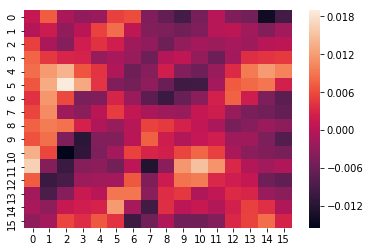

In [96]:
sns.heatmap(nearest[12, :, :, 6] - bicubic[12, :, :, 6])